<h1>Requirements</h1>

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from scipy import stats
import tat_neuro_functions as tnf
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<h1>Import Data</h1>
<p>This data has been preprocessed in a separate notebook. Missing variables were imputed using a "median" approach, which is designated by the "2" in "sklearn_preprocessed_df2". It contains all potential features, both clinical and genetic, prior to further feature engineering.</p>

In [2]:
DF = pd.read_csv('/Users/Greg/Documents/Drexel/ML/sklearn_preprocessed_df2.csv')
DF.head()

,Patient,Visit,Age,Gender,ART,VL,iVL,pVL,CD4,iCD4,...,101F,101P,101S,101T,101W,101Y,101V,log10_VL,log10_iVL,log10_pVL
0,A0001,R09,59.0,Male,on,20.0,987.0,987.0,797.0,400.0,...,0.0,0.000453,0.000356,0.000000,0.000129,0.0,0.001975,1.301030,2.994317,2.994317
1,A0010,R08,59.0,Male,on,20.0,50.0,470.0,1167.0,448.0,...,0.0,0.000000,0.004473,0.001278,0.000000,0.0,0.000000,1.301030,1.698970,2.672098
2,A0012,R02,63.0,Male,on,34.0,2083.0,28550.0,881.0,745.0,...,0.0,0.003399,0.000283,0.000850,0.000000,0.0,0.000142,1.531479,3.318689,4.455606
3,A0013,R09,68.0,Male,on,20.0,144.0,39373.0,771.0,564.0,...,0.0,0.000278,0.003894,0.000278,0.000000,0.0,0.000000,1.301030,2.158362,4.595199
4,A0015,R10,54.0,Male,on,20.0,79074.0,79074.0,561.0,309.0,...,0.0,0.003000,0.000500,0.000400,0.000000,0.0,0.000000,1.301030,4.898034,4.898034


<h2>Genetic Data Representations</h2>
<p>The NGS genetic information can be represented in several different formats that will be compared with regard to their ability to indicate neurocognitive impairment. These representations are:
<ol>
<li>relative abundance of each amino acid for each position
<li>presence/absence of each potential variant at some threshold (0%, 10%, 50%)
<li>consensus amino acid a particular position, represented by its isoelectric point (pI)
</ol>
</p>

In [3]:
genetic_cols = range(15,len(DF.columns)-3)
g_df = tnf.select_dataframe_columns(DF, genetic_cols)
print g_df.shape
g_df.head()

(117, 2021)


,GDS,1A,1R,1N,1D,1C,1Q,1E,1G,1H,...,101L,101K,101M,101F,101P,101S,101T,101W,101Y,101V
0,0.583333,0.000213,0.002378,0.00018,0.000049,0.002477,0.000082,0.004051,0.001247,0.0,...,0.001036,0.0,0.0,0.0,0.000453,0.000356,0.000000,0.000129,0.0,0.001975
1,1.416667,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.004473,0.001278,0.000000,0.0,0.000000
2,0.583333,0.000000,0.001640,0.00000,0.000000,0.000547,0.000000,0.000547,0.000547,0.0,...,0.003682,0.0,0.0,0.0,0.003399,0.000283,0.000850,0.000000,0.0,0.000142
3,0.000000,0.000000,0.001629,0.00000,0.000000,0.000000,0.000000,0.001629,0.000000,0.0,...,0.002410,0.0,0.0,0.0,0.000278,0.003894,0.000278,0.000000,0.0,0.000000
4,1.333333,0.000000,0.006211,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.001600,0.0,0.0,0.0,0.003000,0.000500,0.000400,0.000000,0.0,0.000000


In [4]:
# threshold above %
t1_df = tnf.make_threshold_dataframe(g_df, 0.1)
t5_df = tnf.make_threshold_dataframe(g_df, 0.5)
t9_df = tnf.make_threshold_dataframe(g_df, 0.9)

T1_DF = tnf.filter_genetic_variants(t1_df, 0, 0)
T5_DF = tnf.filter_genetic_variants(t5_df, 0, 0)
T9_DF = tnf.filter_genetic_variants(t9_df, 0, 0)

print T1_DF.shape
print T5_DF.shape
print T9_DF.shape

(117, 421)
(117, 313)
(117, 284)


In [5]:
#con_df = tnf.get_consensus_df(g_df)
#PI_DF = tnf.get_pI_df(con_df)
G_DF = tnf.filter_genetic_variants(g_df, 0.1, 0.1)

In [6]:
# 5 dataframes with genetic data representations
df_list = [G_DF, T1_DF, T5_DF, T9_DF]
for D in df_list:
    print D.shape

(117, 148)
(117, 421)
(117, 313)
(117, 284)


In [7]:
# compare positions that make sense
# combine clinical and genetic data

<h1>Genetic Models</h1>
<p>Models will be similarly compared:</p>
<ul>
<li>All positions
<li>High diversity positions
<li>Presence/Absence
<li>Chemical properties
</ul>

<h1>Default Approach</h1>
<p>Using the same approach as used for clinical data:</p>

In [8]:
def genetic_metrics_wrapper(df, model, folds):
    target = 'GDS'
    threshold = 0.5
    features = list(df.columns[1:])
    df_shuffled = tnf.shuffle_dataframe(df)
    X_df, y = tnf.run_preparation_pipeline(df_shuffled, features, target, threshold)
    d = tnf.get_CV_metrics(model, X_df[features], y, folds)
    return d

def genetic_metrics_wrapper_random(df, model, folds):
    target = 'GDS'
    threshold = 0.5
    features = list(df.columns[1:])
    df_shuffled = tnf.shuffle_dataframe(df)
    X_df, y = tnf.run_preparation_pipeline(df_shuffled, features, target, threshold)
    y_rand = np.random.permutation(y)
    d = tnf.get_CV_metrics(model, X_df[features], y_rand, folds)
    return d

# Univariate Approach (Fisher Exact)

In [9]:
init_df = tnf.make_threshold_dataframe(g_df, 0)
I_DF = tnf.filter_genetic_variants(init_df, 0, 0)

RESULTS = []

for t in np.arange(0.0,1.0,0.05):
    t_df = tnf.make_threshold_dataframe(g_df, t)
    T_DF = tnf.filter_genetic_variants(t_df, 0, 0)
    #print T_DF.shape
    
    # split into 2 groups
    m = T_DF['GDS'] >= 0.5
    D1 = T_DF[m]
    D2 = T_DF[~m]

    variants = list(I_DF.columns[1:])
    #print len(variants)
    for V in variants:
        if V in list(T_DF.columns[1:]):
            var_array1 = D1[V]
            var_array2 = D2[V]
            A = sum(var_array1 == 1)
            B = sum(var_array1 == 0)
            C = sum(var_array2 == 1)
            D = sum(var_array2 == 0)
            CM = [[A,C],[B,D]]
            oddsratio, pvalue = stats.fisher_exact(CM)
            
            res = (t, V, pvalue)
            if pvalue<0.05:
                RESULTS.append(res)

In [10]:
fish_df = pd.DataFrame(RESULTS)
fish_df.columns = ['Threshold','Variant','Pvalue']
fish_df = fish_df[fish_df.Threshold > 0.0]
fish_df.reset_index(inplace=True)
fish_df = fish_df.drop('index', 1)

FISH_DF = fish_df.pivot_table(values='Pvalue',columns='Variant',index='Threshold')

natK = ['15E', '36V', '40Q', '42G', '56Q', '56R', '59H', '59P', '61S', '67G',
        '71E', '71K', '75F', '78A', '93E', '94Q', '95G', '98T', '100G', '101Q']

FISH_DF = FISH_DF[natK]
FISH_DF = FISH_DF.notnull()
FISH_DF.head()

Variant,15E,36V,40Q,42G,56Q,56R,59H,59P,61S,67G,71E,71K,75F,78A,93E,94Q,95G,98T,100G,101Q
Threshold,,,,,,,,,,,,,,,,,,,,
0.05,False,False,True,False,True,False,False,False,False,False,True,False,False,True,True,False,False,True,False,False
0.10,False,False,False,False,False,False,True,False,False,True,True,False,False,True,True,False,False,False,False,False
0.15,True,False,False,False,True,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False
0.20,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False
0.25,False,False,False,False,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,False


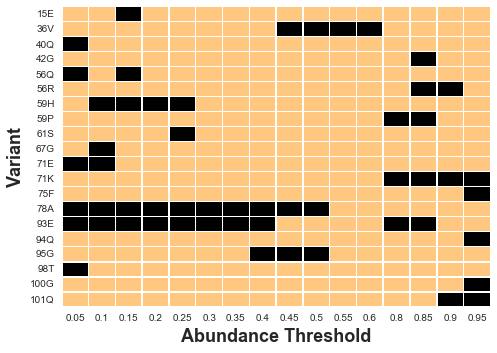

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.heatmap(FISH_DF.T, cbar=None, cmap='copper_r', linewidths=.5)
ax.set_ylabel('Variant', fontsize=18, weight='bold')
ax.set_xlabel('Abundance Threshold', fontsize=18, weight='bold')
fig.tight_layout()
plt.show()

savepath = '/Users/Greg/Documents/Drexel/ML/finalstoryfigs/fisher_exact_genetic.png'
fig.savefig(savepath,dpi=300)

# Univariate Approach (Mann Whitney)

In [12]:
# 
RESULTS = []

# define dataframe
df_list = [G_DF]
for D in df_list:
    results = []
    
    # split into 2 groups
    m = D.GDS >= 0.5
    D1 = D[m]
    D2 = D[~m]

    # iterate through variants
    variants = list(D.columns[1:])
    for V in variants:
        var_array1 = D1[V]
        var_array2 = D2[V]
        if len(np.unique(np.append(var_array1, var_array2))) == 1:
            mw_p = 1.0
        else:
            mw_stat, mw_p = stats.mannwhitneyu(var_array1,var_array2)
        mw_result = (V,mw_p)
        if mw_p < 0.05:
            print mw_result
        results.append(mw_result)
    RESULTS.append(results)   

('36V', 0.0053295413082579375)
('58S', 0.027986580133026174)


# Randomized LASSO approach

<p>Given a small number of observations, we want to recover which features of X are relevant to explain y. For this sparse linear models can outperform standard statistical tests if the true model is sparse, i.e. if a small fraction of the features are relevant.</p>
<p>The ability of L1-based approach to identify the relevant variables depends on the sparsity of the ground truth, the number of samples, the number of features, the conditioning of the design matrix on the signal subspace, the amount of noise, and the absolute value of the smallest non-zero coefficient</p>

In [13]:
from sklearn.linear_model import RandomizedLogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
df_list = [G_DF, T1_DF, T5_DF, T9_DF]

In [42]:
def run_stab_selection(DF):
    threshold = 0.5
    target = 'GDS'
    features = list(DF.columns)[1:]
    X_df, y = tnf.run_genetic_preparation_pipeline(DF, features, target, threshold)
    feats = list(X_df.columns)
    
    Cs = np.linspace(1, 0.1, 100)
    randomized_logistic = RandomizedLogisticRegression(C=Cs,
                                                       scaling=0.5,
                                                       n_resampling=500,
                                                       fit_intercept=True, 
                                                       normalize=False,
                                                       n_jobs=-1, random_state=10)
    randomized_logistic.fit(X_df, y)
    sum_scores = []
    for f, s in zip(feats, randomized_logistic.all_scores_):
        sum_scores.append((f, sum(s), s))
    ss_df = pd.DataFrame(sum_scores)
    ss_df.columns = ['Feature','Sum', 'Scores']
    ss_df.sort_values(by='Sum', inplace=True, ascending=False)
    return ss_df

def plot_stab_selection(ss_df, savepath):
    fig,ax = plt.subplots(figsize=[7,6])
    for s in list(ss_df['Scores']):
        ax.plot(s, color='k', alpha=0.25)
    for i,j in ss_df.iloc[:7].iterrows():
        ax.plot(j['Scores'], label=j['Feature'])
    ax.legend()
    
    # formatting colors and axes
    ax.set_axis_bgcolor('white')
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(2)
    
    ax.set_ylabel('Percentage Selected (500 iterations)', weight='bold', fontsize=18)
    ax.set_xlabel('Regularization Parameter', weight='bold', fontsize=18)
    ax.set_xticks(np.arange(0, 110, 11))
    ax.set_xticklabels(np.linspace(1, 0.1, 10))
    ax.tick_params(axis='x', labelsize=14, length=5)
    ax.tick_params(axis='y', labelsize=14, length=5)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()
    
    fig.tight_layout()
    plt.show()
    fig.savefig(savepath,dpi=300,bbox_inches='tight')

In [16]:
#df_list = [G_DF, T1_DF, T5_DF, T9_DF]
#df_list = [G_DF]
ss_df = run_stab_selection(G_DF)

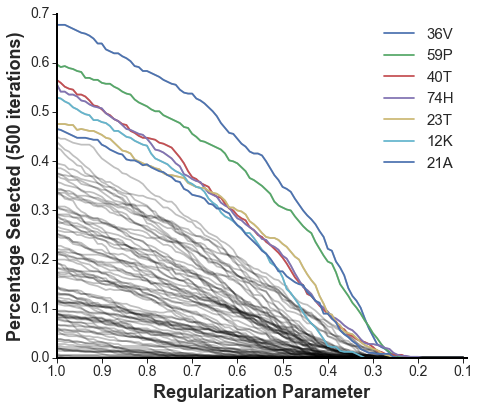

In [43]:
savepath = '/Users/Greg/Documents/Drexel/ML/finalstoryfigs/genetic_feature_selection.png'
plot_stab_selection(ss_df, savepath)

In [44]:
def convert_to_score_df(ss_df):
    all_scores = []
    for slist in ss_df['Scores']:
        all_scores.append(slist)
    score_matrix = np.matrix(all_scores)
    score_df = pd.DataFrame(score_matrix)
    score_df['Feature'] = list(ss_df['Feature'])
    return score_df

score_df = convert_to_score_df(ss_df)
score_df.head()    

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Feature
0,0.678,0.678,0.678,0.674,0.670,0.666,0.662,0.660,0.656,0.650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36V
1,0.598,0.592,0.594,0.590,0.588,0.584,0.582,0.570,0.570,0.566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59P
2,0.566,0.560,0.552,0.548,0.546,0.536,0.536,0.532,0.524,0.514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40T
3,0.558,0.542,0.542,0.536,0.536,0.532,0.524,0.522,0.516,0.512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74H
4,0.476,0.476,0.476,0.474,0.474,0.464,0.466,0.464,0.462,0.462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23T


In [72]:
# information for each model
AUC1, AUC2 = [], []
PREC1, PREC2 = [], []
REC1, REC2 = [], []
F1, F2 = [], []
TPR1, TPR2 = [], []
FPR1, FPR2 = [], []
COEF1, COEF2 = [], []
F_SETS = []

for col in score_df.columns[:-1]:
    mask = score_df[col] > 0.45
    keep_features = list(score_df['Feature'][mask])
    
    if len(keep_features) > 0:
        
        if keep_features not in F_SETS:
            F_SETS.append(keep_features)
            #print keep_features
        
            model_logit = LogisticRegression(penalty='l1',solver='liblinear',fit_intercept=True,
                                             class_weight='balanced',C=1)

            mod_feats = ['GDS'] + keep_features
            df = G_DF[mod_feats]

            # information for each iteration of 100
            auc1, auc2 = [], []
            prec1, prec2 = [], []
            rec1, rec2 = [], []
            f1, f2 = [], []
            tpr1, tpr2 = [], []
            fpr1, fpr2 = [], []
            coef1, coef2 = [], []
        
            for _ in range(100):
                d = genetic_metrics_wrapper(df, model_logit, 5)
                dr = genetic_metrics_wrapper_random(df, model_logit, 5)

                # append all cross validation metrics
                # true model
                auc1.append(np.mean(d['AUC']))
                prec1.append(np.mean(d['Precision']))
                rec1.append(np.mean(d['Recall']))
                f1.append(np.mean(d['F1']))
                tpr1.append(d['meanTPR'])
                fpr1.append(d['meanFPR'])
                coef1.append(d['Coef'])

                # random model
                auc2.append(np.mean(dr['AUC']))
                prec2.append(np.mean(dr['Precision']))
                rec2.append(np.mean(dr['Recall']))
                f2.append(np.mean(dr['F1']))
                tpr2.append(dr['meanTPR'])
                fpr2.append(dr['meanFPR'])
                coef2.append(dr['Coef'])
                
            #append results for each model
            AUC1.append(auc1)
            PREC1.append(prec1)
            REC1.append(rec1)
            F1.append(f1)
            TPR1.append(tpr1) 
            FPR1.append(fpr1) 
            COEF1.append(coef1) 

            #append results for each random model
            AUC2.append(auc2)
            PREC2.append(prec2)
            REC2.append(rec2)
            F2.append(f2)
            TPR2.append(tpr2) 
            FPR2.append(fpr2) 
            COEF2.append(coef2)

In [73]:
F_SETS

[['36V', '59P', '40T', '74H', '23T', '12K', '21A'],
 ['36V', '59P', '40T', '74H', '23T', '12K'],
 ['36V', '59P', '40T', '74H', '12K'],
 ['36V', '59P', '40T', '74H'],
 ['36V', '59P', '74H'],
 ['36V', '59P'],
 ['36V']]

# ROC Plots

In [74]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
normalize = mcolors.Normalize(vmin=min([len(f) for f in F_SETS]), vmax=max([len(f) for f in F_SETS]))
colormap = cm.jet

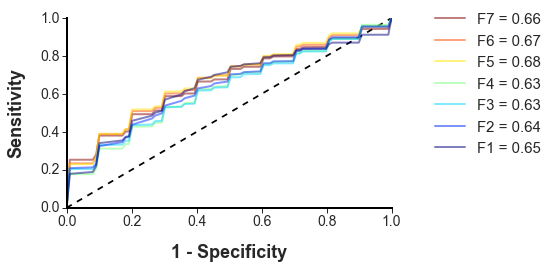

In [105]:
# iterate through the combinations of features

fig,ax=plt.subplots(figsize=(6,4))

# formatting
ax.tick_params(axis='x', labelsize=14, length=5)
ax.tick_params(axis='y', labelsize=14, length=5)
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.set_xlabel('1 - Specificity', size=18, labelpad=15, weight='bold')
ax.set_ylabel('Sensitivity', size=18, labelpad=15, weight='bold')
ax.set_axis_bgcolor('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.ticklabel_format(size=20)
ax.plot([0, 1], [0, 1], ls='--', color='black')
#clrs = ['red','blue','green','purple','orange','deeppink','aqua','gold','lime','sienna']

for j in range(len(F_SETS)):
    # returns a list of arrays
    f = FPR1[j]
    t = TPR1[j]
    a = str(round(np.mean(AUC1[j]),2))
    
    # initialize a mean TRP and FPR
    X = np.zeros(len(f[0]))
    Y = np.zeros(len(t[0]))
    # iterate through each randomization
    for i in range(len(t)):
        X = X + f[i]
        Y = Y + t[i]
    X = X/len(t)
    Y = Y/len(t)
    n = len(F_SETS[j])
    #print n
    ax.plot(X, Y, ls='-', label='F'+str(n)+' = '+a, linewidth=2, alpha=0.5, color=colormap(normalize(n)))

plt.legend(bbox_to_anchor=[1.5, 1.1],ncol=1)
fig.tight_layout()

savepath = '/Users/Greg/Documents/Drexel/ML/finalstoryfigs/gen_roc_plots.png'
fig.savefig(savepath,dpi=300,bbox_inches='tight')

# Comparison of Models

In [76]:
aMean, bMean = [], []
aSTD, bSTD = [], []

for i in range(len(AUC1)):
    aMean.append(np.mean(AUC1[i]))
    aSTD.append(np.std(AUC1[i]))
    bMean.append(np.mean(AUC2[i]))
    bSTD.append(np.std(AUC2[i]))

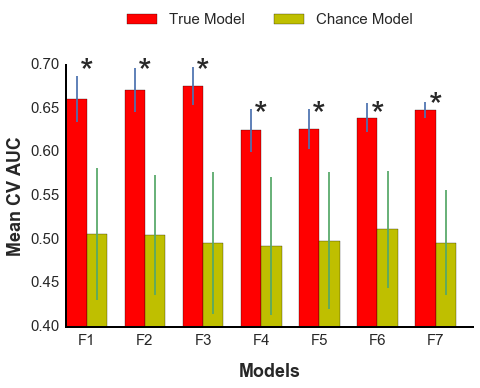

In [95]:
N = len(aMean)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(ind, aMean, width, color='r', yerr=aSTD)
rects2 = ax.bar(ind + width, bMean, width, color='y', yerr=bSTD)

# add some text for labels, title and axes ticks
ax.set_ylabel('Mean CV AUC', weight='bold', fontsize=18)
ax.set_xlabel('Models', labelpad=15, fontsize=18, weight='bold')
ax.set_xticks(ind + width)
labels = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10']
ax.set_xticklabels(labels)
ax.set_ylim([0.4,0.7])

ax.legend((rects1[0], rects2[0]), ('True Model', 'Chance Model'),
          loc='upper center', bbox_to_anchor=(0.5, 1.25),ncol=2, fancybox=True)

# formatting colors and axes
ax.set_axis_bgcolor('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)

ax.text(0.23,0.68,'*',fontsize=35)
ax.text(1.23,0.68,'*',fontsize=35)
ax.text(2.23,0.68,'*',fontsize=35)
ax.text(3.23,0.63,'*',fontsize=35)
ax.text(4.23,0.63,'*',fontsize=35)
ax.text(5.23,0.63,'*',fontsize=35)
ax.text(6.23,0.64,'*',fontsize=35)


fig.tight_layout()
savepath = '/Users/Greg/Documents/Drexel/ML/finalstoryfigs/gen_auc_true_chance.png'
fig.savefig(savepath,dpi=300,bbox_inches='tight')

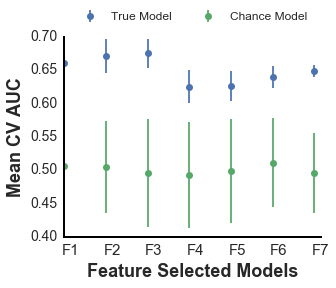

In [84]:
fig, ax = plt.subplots(figsize=(5,4))
N = len(aMean)
width = 0.15 
ind = np.arange(1,N+1,1)

ax.errorbar(ind, aMean, yerr=aSTD, fmt='o', label='True Model')
ax.errorbar(ind, bMean, yerr=bSTD, fmt='o', label='Chance Model')

# add some text for labels, title and axes ticks
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Mean CV AUC', weight='bold', fontsize=18)
ax.set_xlabel('Feature Selected Models', labelpad=5, fontsize=18, weight='bold')
ax.set_xticks(ind + width)
ax.set_xticklabels(['F1','F2','F3','F4','F5','F6','F7'])
ax.set_ylim([0.4,0.7])

ax.set_axis_bgcolor('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)

ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.18),ncol=2, fancybox=True)

fig.tight_layout()
#savepath = '/Users/Greg/Documents/Drexel/ML/finalstoryfigs/gen_auc_true_chance.png'
#fig.savefig(savepath,dpi=300,bbox_inches='tight')

# Coefficients

In [97]:
coeff_dict_list = []
i=0
for feature_group in COEF1:
    F = F_SETS[i]
    #print len(F),
    cv_mean_list = []
    for cv_group in feature_group:
        cv_mean = np.mean(cv_group,0)
        cv_mean_list.append(cv_mean)
    S = np.mean(cv_mean_list,0)[0]
    #print len(S)
    Z = zip(F,S)
    coeff_dict_list.append(dict(Z))
    i+=1
    
X = []
VARS = F_SETS[0]
for A in coeff_dict_list:
    x = []
    for V in VARS:
        if V in A.keys():
            x.append(A[V])
        else:
            x.append(np.nan)
    X.append(x)

coeff_df = pd.DataFrame(X)
coeff_df.columns = VARS
#coeff_df.T

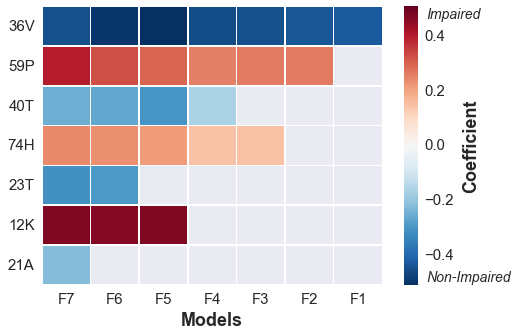

In [112]:
sns.set(font_scale=1.5)
fig,ax = plt.subplots(figsize=(7,5))
ax = sns.heatmap(coeff_df.T, linewidths=.5)
VARS = reversed(F_SETS[0])
#ax.set_yticklabels(VARS, rotation="90")
#ax.set_xticklabels('')
labels = reversed(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7'])
ax.set_xticklabels(labels)

ax.set_xlabel('Models', labelpad=5, fontsize=18, weight='bold')
ax.yaxis.set_label_position('right')
ax.set_ylabel('Coefficient', fontsize=18, weight='bold', labelpad=80)
ax.legend(fontsize=16)
fig.tight_layout()
plt.yticks(rotation=0) 

ax.text(7.9,0.1,'Non-Impaired',fontsize=14,fontstyle='italic')
ax.text(7.9,6.7,'Impaired',fontsize=14,fontstyle='italic')

plt.show()

savepath = '/Users/Greg/Documents/Drexel/ML/finalstoryfigs/genetic_roc_coeff.png'
fig.savefig(savepath,dpi=300,bbox_inches='tight')

In [25]:
# patient selection

# Add features to genetic + clinical features